In [ ]:
!unzip -q /content/drive/MyDrive/data.zip -d .

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
data_dir = 'plates'

In [ ]:
def get_dataloader(type_set='train', transforms=[], batch_size=8):
        """
        Получение даталоадера
        """
        if type_set == 'train':
            type_set = os.path.join(data_dir,type_set)
            if transforms == []:
                dataset = torchvision.datasets.ImageFolder(type_set)
            elif len(transforms) == 1:
                dataset = torchvision.datasets.ImageFolder(type_set, transforms[0])
            else:
                dataset = torchvision.datasets.ImageFolder(type_set, transforms[0])
                for transform in transforms[1:]:
                    dataset += torchvision.datasets.ImageFolder(type_set, transform)
            return torch.utils.data.DataLoader(dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True, 
                                               num_workers=4)
        elif type_set == 'val':
            type_set = os.path.join(data_dir,type_set)
            if transforms == []:
                dataset = torchvision.datasets.ImageFolder(type_set)
            elif len(transforms) == 1:
                dataset = torchvision.datasets.ImageFolder(type_set, transforms[0])
            else:
                dataset = torchvision.datasets.ImageFolder(type_set, transforms[0])
                for transform in transforms[1:]:
                    dataset += torchvision.datasets.ImageFolder(type_set, transform)
            return torch.utils.data.DataLoader(dataset, 
                                               batch_size=batch_size, 
                                               shuffle=False, 
                                               num_workers=4)
        else:
            print("НЕ ВЕРНЫЙ ПАРАМЕТР type_set")

In [ ]:
train_transforms1 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_transforms2 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_transforms3 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_transforms4 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_transforms5 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms6 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomGrayscale(),
    transforms.ColorJitter(),
    transforms.RandomRotation(degrees=90, fill=255),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms7 = transforms.Compose([
    transforms.CenterCrop(180),
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_transforms = [train_transforms1,train_transforms2, train_transforms3, train_transforms1, train_transforms4, train_transforms5, train_transforms6, train_transforms7]

val_transforms = [val_transforms]

In [ ]:
batch_size = 8

In [ ]:
train_dataloader = get_dataloader(type_set='train', transforms=train_transforms, batch_size=batch_size)
val_dataloader = get_dataloader(type_set='val', transforms=val_transforms, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


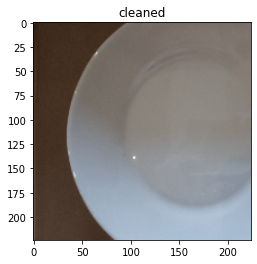

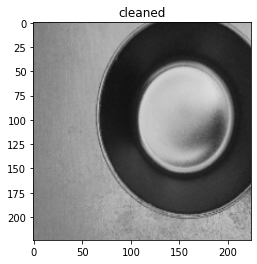

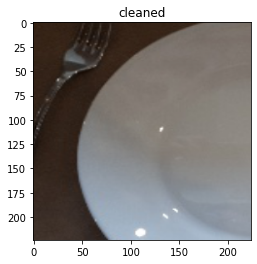

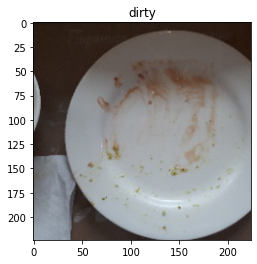

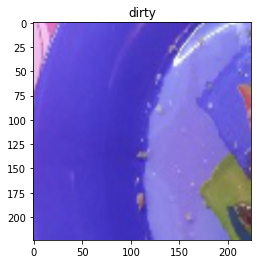

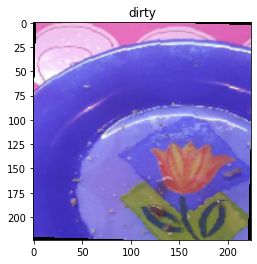

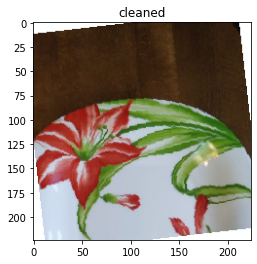

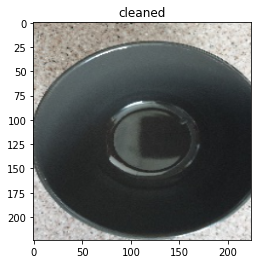

In [ ]:
def show_input(input_tensor, title=''):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))
class_names = ['cleaned','dirty']
for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
val_loss_history = []
train_loss_history = []
def train_model(model, loss, optimizer, scheduler, num_epochs):
    """
    Обучение модели
    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train() 
            else:
                dataloader = val_dataloader
                model.eval() 
            running_loss = 0.
            running_acc = 0.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            elif phase == 'val':
                val_loss_history.append(epoch_loss)
            if phase == 'val' and epoch_acc > best_acc:
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

for param in model.avgpool.parameters():
    param.requires_grad = True    

for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = torch.nn.Sequential(
            torch.nn.Linear(model.fc.in_features, 256),
            torch.nn.GELU(),
            torch.nn.Linear(256, 2))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.1,momentum=0.85)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=10)

Epoch 0/9:


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.4266 Acc: 0.8125
val Loss: 1.5218 Acc: 0.6250
Epoch 1/9:
train Loss: 0.2596 Acc: 0.9102
val Loss: 0.3997 Acc: 0.7500
Epoch 2/9:
train Loss: 0.2489 Acc: 0.9180
val Loss: 0.3615 Acc: 0.8750
Epoch 3/9:
train Loss: 0.2005 Acc: 0.9258
val Loss: 1.6600 Acc: 0.6250
Epoch 4/9:
train Loss: 0.1111 Acc: 0.9453
val Loss: 0.7175 Acc: 0.7500
Epoch 5/9:
train Loss: 0.3763 Acc: 0.9141
val Loss: 1.8937 Acc: 0.5000
Epoch 6/9:
train Loss: 0.3167 Acc: 0.8633
val Loss: 1.3212 Acc: 0.5000
Epoch 7/9:
train Loss: 0.1778 Acc: 0.9414
val Loss: 1.2021 Acc: 0.5000
Epoch 8/9:
train Loss: 0.1730 Acc: 0.9531
val Loss: 1.1010 Acc: 0.5000
Epoch 9/9:
train Loss: 0.1213 Acc: 0.9727
val Loss: 1.0662 Acc: 0.5000


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

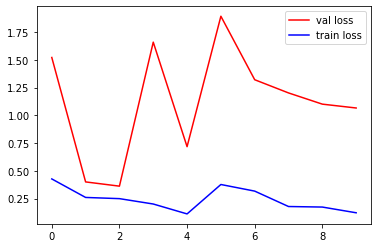

In [ ]:
def show_history():
    plt.plot(range(len(val_loss_history)),val_loss_history,color='red',label='val loss')
    plt.plot(range(len(train_loss_history)),train_loss_history,color='blue',label='train loss')
    plt.legend()
    plt.show()
show_history()

In [ ]:
class ImageFolderWithPath(torchvision.datasets.ImageFolder):
    def __getitem__(self,index):
        original_tuple = super(ImageFolderWithPath,self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
test_dir = 'test'

In [ ]:
test_dataset = ImageFolderWithPath(test_dir,val_transforms[0])

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def test_predict(model):
    """
    Предсказание на тестовой выборке
    """
    model.eval()
    test_predictions = []
    test_img_paths = []
    for inputs, labels, paths in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        test_img_paths.extend(paths)
    
    return test_img_paths, np.concatenate(test_predictions)
test_img_paths, test_predictions = test_predict(model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


8
torch.Size([8, 3, 224, 224])
744


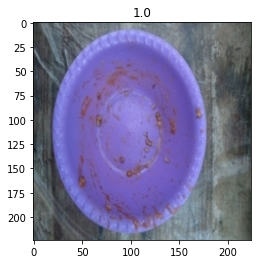

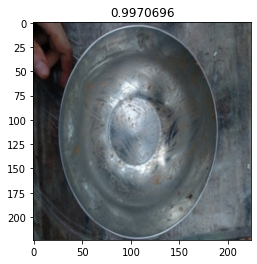

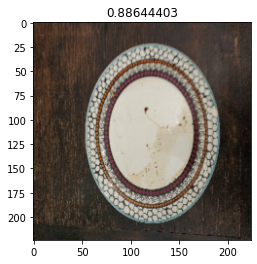

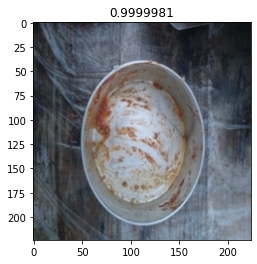

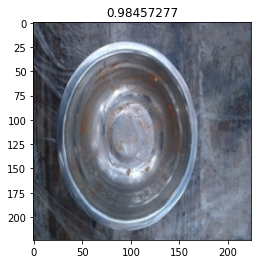

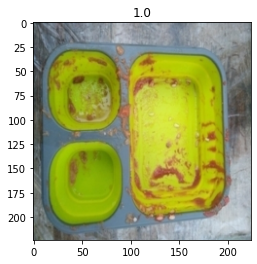

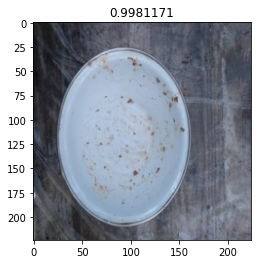

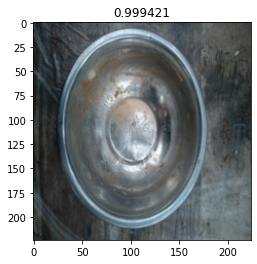

In [ ]:
inputs,labels,paths = next(iter(test_dataloader))
print(len(inputs))
print(inputs.shape)
print(len(test_predictions))
for img,pred in zip(inputs,test_predictions):
    show_input(img,title=pred)

In [ ]:
import pandas as pd
def get_submission_df(thresh=0.5):
    """
    Получение датафрейма для проверки итогов соревнования
    """
    l = len('test/unknown/')
    submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
    submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > thresh else 'cleaned')
    submission_df['id'] = submission_df['id'].str[l:]
    submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
    submission_df.set_index('id', inplace=True)
    submission_df.head(n=6)
    
    return submission_df

In [ ]:
submission_df = get_submission_df(thresh=0.5)
submission_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty


In [ ]:
submission_df.to_csv('submission10.csv')

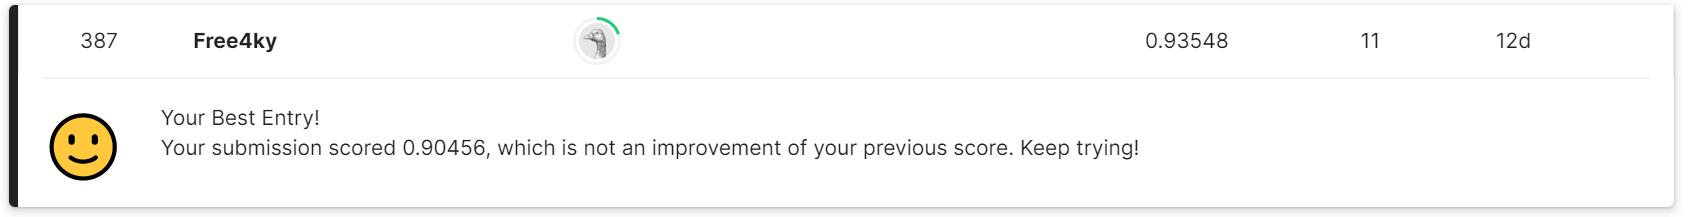